In [19]:
import os
import json
import torch
import numpy as np
from sklearn.model_selection import train_test_split

def load(scenario=1, block_size='4k', subset='train'):
  if block_size not in ['512', '4k']:
    raise ValueError('Invalid block size!')
  if scenario not in range(1, 7):
    raise ValueError('Invalid scenario!')
  if subset not in ['train', 'val', 'test']:
    raise ValueError('Invalid subset!')

  data_dir = os.path.join('./dataset', '{:s}_{:1d}'.format(block_size, scenario))
  data = np.load(os.path.join(data_dir, '{}.npz'.format(subset)))
 
  if os.path.isfile('classes.json'):
    with open('classes.json') as json_file:
      classes = json.load(json_file)
      labels = classes[str(scenario)]
  else:
    raise FileNotFoundError('Please download classes.json to the current directory!')

  return data['x'], data['y'], labels

x, y, labels = load(3, '4k', 'train')
print("Loaded data: x.shape={}, y.shape={}".format(x.shape, y.shape))

Loaded data: x.shape=(1884960, 4096), y.shape=(1884960,)


In [20]:
num_classes = len(labels)
print(num_classes)
print(labels)

25
['jpg', 'arw', 'cr2', 'dng', 'gpr', 'nef', 'nrw', 'orf', 'pef', 'raf', 'rw2', '3fr', 'tiff', 'heic', 'bmp', 'gif', 'png', 'mov', 'mp4', '3gp', 'avi', 'mkv', 'ogv', 'webm', 'oth']


In [ ]:
# Create PyTorch Datasets & DataLoaders
x_tensor = torch.tensor(x, dtype=torch.uint8)  # assuming x contains int byte values (0-255 + padding)
del x
y_tensor = torch.tensor(y, dtype=torch.uint8)
del y
train_dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
del x_tensor
del y_tensor
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=2)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    num_workers=6,
)

del train_dataset

In [2]:
x, y, labels = load(3, '4k', 'test')

In [3]:

x_tensor = torch.tensor(x, dtype=torch.uint8)  # assuming x contains int byte values (0-255 + padding)
del x
y_tensor = torch.tensor(y, dtype=torch.uint8)
del y
test_dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
del x_tensor
del y_tensor
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=6)
del test_dataset

In [6]:
x, y, labels = load(3, '4k', 'val')

In [7]:

x_tensor = torch.tensor(x, dtype=torch.uint8)  # assuming x contains int byte values (0-255 + padding)
del x
y_tensor = torch.tensor(y, dtype=torch.uint8)
del y
val_dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
del x_tensor
del y_tensor
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
del val_dataset


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, gru_output):
        # gru_output: (B, L, H)
        attn_weights = F.softmax(self.attn(gru_output), dim=1)  # (B, L, 1)
        context = torch.sum(attn_weights * gru_output, dim=1)   # (B, H)
        return context

class CNN_GRU_Attn_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(CNN_GRU_Attn_Classifier, self).__init__()

        self.embedding_dim = 64
        self.vocab_size = 257  # 0–255 + 1 for PAD

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=256
        )

        # CNN layers
        self.conv1 = nn.Conv1d(self.embedding_dim, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

        # GRU layer
        self.gru = nn.GRU(input_size=256, hidden_size=128, num_layers=1,
                          batch_first=True, bidirectional=True)

        # Attention Layer
        self.attention = Attention(hidden_dim=128 * 2)  # Bidirectional GRU output

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)        # (B, L, D)
        x = x.permute(0, 2, 1)       # (B, D, L)

        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3(self.conv3(x))))  # (B, 256, L_out)

        x = x.permute(0, 2, 1)       # (B, L_out, 256)
        gru_out, _ = self.gru(x)     # (B, L_out, 2*128)

        x = self.attention(gru_out)  # (B, 2*128)

        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.fc2(x)

        return x




In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
device

device(type='cuda')

In [7]:
model = CNN_GRU_Attn_Classifier(num_classes=25).to(device)



In [15]:
labels

tensor([14,  4, 10, 20], device='cuda:0', dtype=torch.uint8)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)



In [9]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


In [14]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        
        # Wrap your DataLoader in tqdm
        batch_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for X, y in batch_iter:
            # send to device and cast to long only per‑batch
            X = X.to(device).long()
            y = y.to(device).long()
            
            # forward / backward
            y_pred = model(X)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            current_n = batch_iter.n if batch_iter.n > 0 else 1
            batch_iter.set_postfix(loss=total_loss / current_n)
        
        avg_loss = total_loss / len(train_loader)
        print(f"→ Epoch {epoch+1} complete. Avg Loss: {avg_loss:.4f}")
        # scheduler.step()


In [10]:
def test_model(model, test_loader, criterion,scheduler ,device=device):
    model.eval()  # Set model to evaluation mode
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        
        for X, y in test_loader:
            X, y = X.to(torch.long).to(device), y.to(torch.long).to(device)

            test_pred = model(X)  # Forward pass
            loss = criterion(test_pred, y)  # Compute loss
            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    scheduler.step(test_loss)



In [ ]:


train_model(model, train_loader, criterion, optimizer, num_epochs=1)
test_model(model, val_loader,criterion,scheduler)


 

Epoch 1/1: 100%|██████████| 14727/14727 [1:34:29<00:00,  2.60batch/s, loss=0.212]  


→ Epoch 1 complete. Avg Loss: 0.2117
Test Loss: 0.2075, Accuracy: 91.93%


In [12]:
test_model(model, test_loader,criterion,scheduler)


Test Loss: 0.2067, Accuracy: 91.90%


In [18]:
torch.save(model.state_dict(),'./models/FFT3-4epocs.pth')

In [11]:
model.load_state_dict(torch.load('./models/FFT3-4epocs.pth', weights_only=True))

<All keys matched successfully>

In [18]:
s2_weights_path = './models/FFT2-12epocs.pth' # <<<=== MAKE SURE THIS PATH IS CORRECT

try:
    print(f"\nAttempting to load pre-trained weights from: {s2_weights_path}")
    # Load the state dict from the Scenario 2 model
    s2_state_dict = torch.load(s2_weights_path, map_location=device)

    # Get the state dict of the newly initialized Scenario 3 model
    model_s3_dict = model.state_dict() # Uses the 'model' variable from above

    # 1. Filter out unnecessary keys (like the final classifier 'fc2.weight' and 'fc2.bias')
    #    and keys with shape mismatches.
    pretrained_dict = {k: v for k, v in s2_state_dict.items() if k in model_s3_dict and model_s3_dict[k].shape == v.shape}

    # 2. Overwrite entries in the existing state dict with the filtered pretrained weights
    model_s3_dict.update(pretrained_dict)

    # 3. Load the new state dict into the Scenario 3 model
    model.load_state_dict(model_s3_dict)

    num_loaded_layers = len(pretrained_dict)
    print(f"Successfully loaded {num_loaded_layers} layers from the Scenario 2 model.")
    if 'fc2.weight' not in pretrained_dict:
        print("NOTE: The final classification layer (fc2) was intentionally *not* loaded due to class mismatch and remains randomly initialized.")
    else:
         print("Warning: fc2 layer was loaded - check num_classes consistency if this was unexpected.")

except FileNotFoundError:
    print(f"Warning: Pre-trained weights file not found at '{s2_weights_path}'. Training Scenario 3 model from scratch.")
except Exception as e:
    print(f"Warning: An error occurred while loading pre-trained weights: {e}. Training Scenario 3 model from scratch.")


Attempting to load pre-trained weights from: ./models/FFT2-12epocs.pth
Successfully loaded 34 layers from the Scenario 2 model.
NOTE: The final classification layer (fc2) was intentionally *not* loaded due to class mismatch and remains randomly initialized.


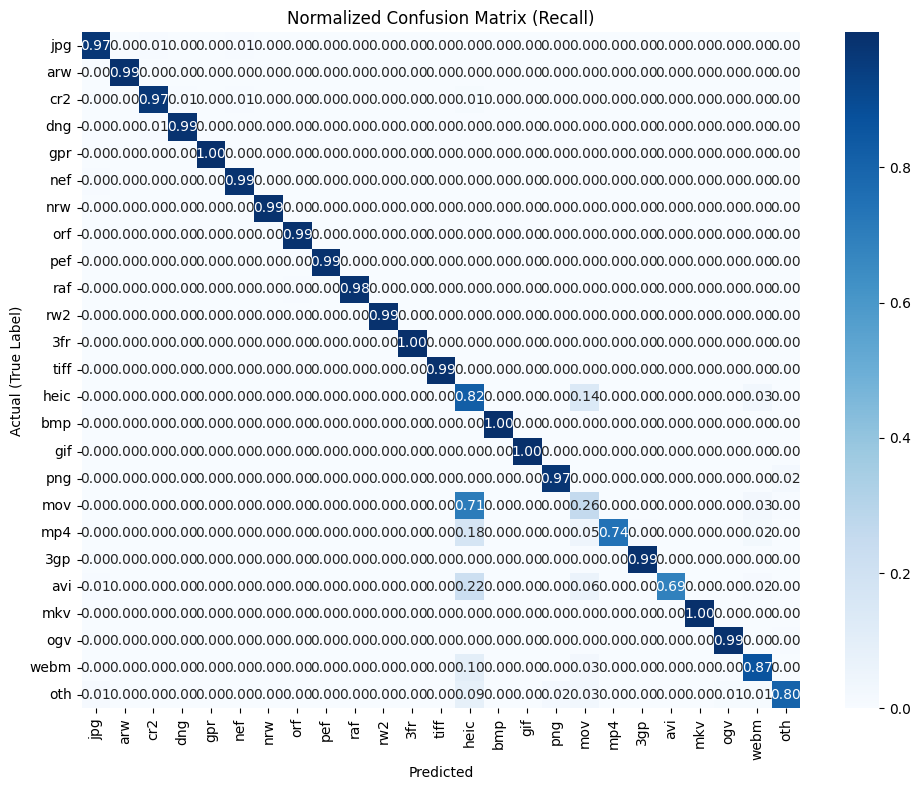

In [21]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
all_preds = []
all_labels = []

# Step 1: Get predictions and true labels

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs.long())
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)


cm_sum = cm.sum(axis=1, keepdims=True)
# Handle cases where a row sum is 0 to avoid division by zero -> NaN
with np.errstate(divide='ignore', invalid='ignore'):
    cm_normalized = cm.astype('float') / cm_sum
    cm_normalized = np.nan_to_num(cm_normalized) # Replace NaN with 0

# Ensure class_names is defined correctly before this point:
class_names = ['jpg', 'arw', 'cr2', 'dng', 'gpr', 'nef', 'nrw', 'orf', 'pef', 'raf', 'rw2', '3fr', 'tiff', 'heic', 'bmp', 'gif', 'png', 'mov', 'mp4', '3gp', 'avi', 'mkv', 'ogv', 'webm', 'oth'] # Example

# Step 4: Plot the NORMALIZED confusion matrix
plt.figure(figsize=(10, 8)) # Adjust size if needed
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', # Use '.2f' for float format
            xticklabels=class_names, yticklabels=class_names) # USE class_names HERE
plt.xlabel('Predicted')
plt.ylabel('Actual (True Label)')
plt.title('Normalized Confusion Matrix (Recall)') # Update title
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np

def calculate_evaluation_metrics(y_true, y_pred, class_names, average_method='weighted'):
    """
    Calculates and prints evaluation metrics (accuracy, precision, recall, F1).

    Args:
        y_true (list or np.array): Ground truth labels (integers or strings).
        y_pred (list or np.array): Predicted labels (integers or strings).
        class_names (list): List of strings representing the class names,
                           in the order corresponding to label indices if y_true/y_pred
                           are integers starting from 0. If y_true/y_pred are already
                           strings, these names are used for the report.
        average_method (str, optional): Type of averaging for precision, recall, F1.
                                        Options: 'micro', 'macro', 'weighted', None.
                                        Defaults to 'weighted'. If None, scores for
                                        each class are returned but not averaged.
    """

    if len(y_true) != len(y_pred):
        print("Error: y_true and y_pred must have the same length.")
        return None

    print("--- Evaluation Metrics ---")

    # --- Overall Accuracy ---
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # --- Precision, Recall, F1-Score ---
    # Use labels=class_names if y_true/y_pred contain strings, otherwise map indices if needed
    # For simplicity, assuming y_true/y_pred contain labels directly comparable or indices 0..N-1
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        average=average_method, # Calculate the chosen average
        zero_division=0 # Avoids warning/error if a class has no support/predictions
    )

    print(f"\nMetrics (Average: '{average_method}'):")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    # Support is not usually reported for averages, but available from classification_report

    # --- Detailed Classification Report ---
    print("\nClassification Report (Per Class & Averages):")
    # Ensure labels are correctly passed if y_true/y_pred are indices
    # If y_true/y_pred are strings, target_names might not be needed if strings match class_names
    try:
        # Attempt using target_names based on the provided class_names list
        # This assumes y_true/y_pred are indices 0 to len(class_names)-1
        report = classification_report(
            y_true,
            y_pred,
            target_names=labels,
            zero_division=0,
            digits=3
        )
    except ValueError:
        # If target_names causes issues (e.g., y_true/y_pred are strings
        # or indices don't perfectly match), generate report without them.
        print("(Warning: Generating report without explicit target names due to potential label mismatch)")
        report = classification_report(
            y_true,
            y_pred,
            zero_division=0,
            digits=3
        )

    print(report)

    # --- Return calculated metrics (optional) ---
    metrics = {
        'accuracy': accuracy,
        f'{average_method}_precision': precision,
        f'{average_method}_recall': recall,
        f'{average_method}_f1': f1,
        'classification_report': report
    }
    return metrics


# --- EXAMPLE USAGE ---

# Assume you have your true labels and predictions from your model evaluation
# Example Data (replace with your actual data):
# Option 1: Labels are indices (0, 1, 2...)
# y_true_indices = np.array([0, 1, 2, 0, 1, 2, 0, 0, 1, 2])
# y_pred_indices = np.array([0, 1, 1, 0, 1, 2, 1, 0, 1, 2])
# class_names_list = ['Class A', 'Class B', 'Class C']

# Option 2: Labels are strings
# y_true_strings = ['cat', 'dog', 'dog', 'cat', 'bird', 'cat', 'dog', 'bird']
# y_pred_strings = ['cat', 'dog', 'cat', 'cat', 'bird', 'dog', 'dog', 'bird']
# class_names_list = ['cat', 'dog', 'bird'] # Should contain all unique labels

# --- Replace with your actual data ---
# Example using the string data above:# Example for S2

# Call the evaluation function
calculated_metrics = calculate_evaluation_metrics(
    y_true=all_labels,      # Pass the collected true labels
    y_pred=all_preds,       # Pass the collected predicted labels
    class_names=labels # Pass the corresponding class names
)

# You can access the returned dictionary if needed:
# if calculated_metrics:
#     print("\nReturned Weighted F1:", calculated_metrics['weighted_f1'])

--- Evaluation Metrics ---
Overall Accuracy: 91.90%

Metrics (Average: 'weighted'):
  Precision: 0.937
  Recall:    0.919
  F1-Score:  0.922

Classification Report (Per Class & Averages):
(Warning: Generating report without explicit target names due to potential label mismatch)
              precision    recall  f1-score   support

           0      0.959     0.971     0.965      9546
           1      0.994     0.993     0.993      9501
           2      0.975     0.970     0.973      9448
           3      0.985     0.986     0.986      9284
           4      1.000     0.999     1.000      9372
           5      0.968     0.988     0.978      9442
           6      0.989     0.990     0.990      9459
           7      0.989     0.990     0.990      9443
           8      0.996     0.988     0.992      9369
           9      0.996     0.984     0.990      9371
          10      0.991     0.991     0.991      9535
          11      0.997     0.996     0.996      9374
          12      